<a href="https://colab.research.google.com/github/addinar/permafrost-modeling-convlstm/blob/main/model/notebooks/train_test_phase.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Packages and Libraries**

In [1]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

- Have `convlstm.py` and `dataset.py` loaded in colab files.

In [2]:
import sys
sys.path.append('/content')

In [3]:
import pandas as pd
import numpy as np
import os
import torch

In [4]:
from google.colab import drive, userdata
drive.mount('/content/drive')

Mounted at /content/drive


# **Load and Inspect DF**

In [5]:
dataset_path = userdata.get('preprocessed_path')
df = pd.read_csv(dataset_path)

In [6]:
df.columns

Index(['Unnamed: 0', 'date', 'snow_albedo', 'snow_cover', 'snow_density',
       'snow_depth', 'snowfall_sum', 'surface_latent_heat_flux_sum',
       'surface_sensible_heat_flux_sum',
       'surface_solar_radiation_downwards_sum',
       'surface_thermal_radiation_downwards_sum', 'skin_temperature',
       'total_precipitation_sum', 'avg_volumetric_water_content',
       'TBFI_skin_temperature', 'TBFI_soil_temperature_level_1',
       'TBFI_soil_temperature_level_2', 'TBFI_soil_temperature_level_3',
       'band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6'],
      dtype='object')

In [7]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
df.shape

(50262, 23)

In [9]:
df.isna().sum()

,0
date,0
snow_albedo,0
snow_cover,0
snow_density,0
snow_depth,0
snowfall_sum,0
surface_latent_heat_flux_sum,0
surface_sensible_heat_flux_sum,0
surface_solar_radiation_downwards_sum,0
surface_thermal_radiation_downwards_sum,0


Add an additional col 'Year'.

In [10]:
df['date'] = pd.to_datetime(df['date'])
df['Year'] = df['date'].dt.year

In [11]:
df['Year'].unique()

array([2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023], dtype=int32)

In [12]:
# check the size of each year
band_1 = df[df['band_1'] == 1]
band_2 = df[df['band_2'] == 1]
band_3 = df[df['band_3'] == 1]
band_4 = df[df['band_4'] == 1]
band_5 = df[df['band_5'] == 1]
band_6 = df[df['band_6'] == 1]

In [13]:
bands = [band_1, band_2, band_3, band_4, band_5, band_6]
days_in_year = set()
for band in bands:
  for year in band['Year'].unique():
    size = band[band['Year'] == year].shape[0]
    days_in_year.add(size)

print(days_in_year)

{364, 365}


So we know that there is not much variation for number of days in a year. This will make sequencing more straightforward.

# **Train-Test Split**

Make sure to be band-conscious during the split so band data does not leak.

Create sliding-window sequences.

In [14]:
band_cols = ['band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6']

In [15]:
X_train_list, y_train_list = [], []
X_test_list, y_test_list = [], []

In [16]:
not_features = ['date', 'Year', 'TBFI_skin_temperature',
                'TBFI_soil_temperature_level_1', 'TBFI_soil_temperature_level_2',
                'TBFI_soil_temperature_level_3']

targets = ['TBFI_skin_temperature', 'TBFI_soil_temperature_level_1',
           'TBFI_soil_temperature_level_2', 'TBFI_soil_temperature_level_3']

features = df.drop(columns=not_features, axis=1).columns

In [17]:
window_size = 2

In [18]:
for col in band_cols:
  data = df[df[col] == 1].reset_index(drop=True) # filter by band
  X_windows = np.lib.stride_tricks.sliding_window_view(data[features], (window_size, len(features)))
  X_windows = X_windows.reshape(-1, window_size, len(features))

  y_windows = data[targets].values[window_size:]

  split_index = np.where(data['Year'].values[window_size:] <= 2018)[0]
  test_index = np.where(data['Year'].values[window_size:] > 2018)[0]

  X_train_list.append(X_windows[split_index])
  y_train_list.append(y_windows[split_index])

  X_test_list.append(X_windows[test_index])
  y_test_list.append(y_windows[test_index])

In [36]:
X_train = torch.tensor(np.concatenate(X_train_list), dtype=torch.float32)
y_train = torch.tensor(np.concatenate(y_train_list), dtype=torch.float32)
X_test = torch.tensor(np.concatenate(X_test_list), dtype=torch.float32)
y_test = torch.tensor(np.concatenate(y_test_list), dtype=torch.float32)

In [20]:
print("Training Data Shapes:", X_train.shape, y_train.shape)
print("Testing Data Shapes:", X_test.shape, y_test.shape)

Training Data Shapes: torch.Size([39324, 2, 18]) torch.Size([39324, 4])
Testing Data Shapes: torch.Size([10926, 2, 18]) torch.Size([10926, 4])


# **Initialize Dataset and Dataloaders**

In [21]:
from dataset import PermafrostDataset
from torch.utils.data import DataLoader

In [22]:
train_dataset = PermafrostDataset(X_train, y_train)
test_dataset = PermafrostDataset(X_test, y_test)

In [97]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [24]:
len(train_loader) # num batches per epoch

9831

# **Training Loop**

In [91]:
from torch.optim import Adam
from convlstm import ConvLSTM
from torch.nn import MSELoss
import torch.nn as nn

In [98]:
model = ConvLSTM(input_features=len(features))
optimizer = Adam(model.parameters(), lr=1e-3)
# old optimizer =  Adam(model.parameters(), lr=5e-5, weight_decay=1e-5)
loss_fn = MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

In [93]:
def clip_gradients(model, max_norm=1.0):
    for param in model.parameters():
        torch.nn.utils.clip_grad_norm_(param, max_norm)

In [94]:
import matplotlib.pyplot as plt

In [99]:
epoch_losses = []

def train_model(model, train_loader, epochs=100):
    model.train()
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}")
        epoch_loss = 0

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            preds = model(X_batch)
            loss = loss_fn(preds, y_batch)
            loss.backward()

            if batch_idx % 1000 == 0:
              print(f"\n[Batch {batch_idx}] Gradient Norms:")
              for name, param in model.named_parameters():
                  if param.grad is not None:
                      print(f"{name} grad norm: {param.grad.norm().item()}")

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            epoch_loss += loss.item()

            if batch_idx % 1000 == 0:
                print(f"[Batch {batch_idx}] Loss: {loss.item():.4f}")

        print(f"Total Epoch Loss: {epoch_loss:.4f}")
        epoch_losses.append(epoch_loss)

        scheduler.step()

    import matplotlib.pyplot as plt
    plt.plot(epoch_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

Streaming output truncated to the last 5000 lines.
h0 grad norm: 0.026819352060556412
c0 grad norm: 0.029844041913747787
conv1.weight grad norm: 0.5429704189300537
conv1.bias grad norm: 1.1783522602115681e-08
batch_norm.weight grad norm: 0.0625041201710701
batch_norm.bias grad norm: 0.0533536821603775
lstm.weight_ih_l0 grad norm: 0.3180775046348572
lstm.weight_hh_l0 grad norm: 0.13201627135276794
lstm.bias_ih_l0 grad norm: 0.03465455397963524
lstm.bias_hh_l0 grad norm: 0.03465455397963524
fc.weight grad norm: 0.8212843537330627
fc.bias grad norm: 0.2831479609012604
[Batch 3000] Loss: 0.3376

[Batch 4000] Gradient Norms:
h0 grad norm: 0.038437627255916595
c0 grad norm: 0.03731486573815346
conv1.weight grad norm: 0.6882894039154053
conv1.bias grad norm: 1.0163770269855377e-08
batch_norm.weight grad norm: 0.06616795808076859
batch_norm.bias grad norm: 0.055367689579725266
lstm.weight_ih_l0 grad norm: 0.31011390686035156
lstm.weight_hh_l0 grad norm: 0.09454593807458878
lstm.bias_ih_l0 grad

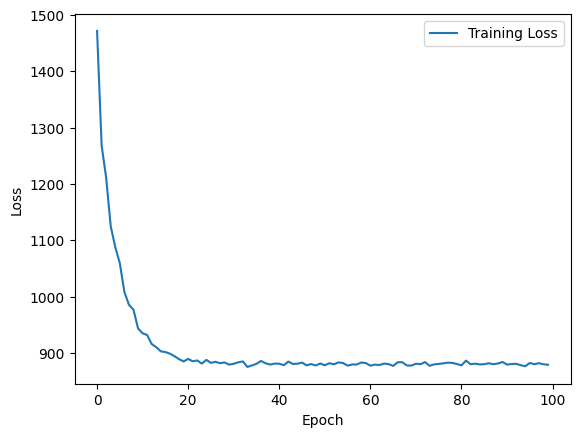

In [100]:
train_model(model, train_loader)

# **Evaluation Loop**

In [101]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [102]:
model.eval()
all_preds, all_targets = [], []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        preds = model(batch_X)
        all_preds.append(preds)
        all_targets.append(batch_y)

In [103]:
all_preds = torch.cat(all_preds, dim=0).cpu().numpy()
all_targets = torch.cat(all_targets, dim=0).cpu().numpy()

In [106]:
mse = mean_squared_error(all_targets, all_preds)
mae = mean_absolute_error(all_targets, all_preds)
r2 = r2_score(all_targets, all_preds)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")

MSE: 0.2657
MAE: 0.3696
R² Score: 0.8110


# **Save Model**

In [107]:
torch.save(model.state_dict(), 'convlstm.pth')